In [1]:
import pandas as pd
from datetime import datetime
import MetaTrader5 as mt5
import pytz
import sys
import pickle
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, max_error, median_absolute_error, r2_score, explained_variance_score
from Optimize_Portfolio import PortfolioManagement
from Long_Short_Term_Memory import Long_Short_Term_Memory
from Neural_Attention_Mechanism import Neural_Attention_Mechanism
from imblearn.over_sampling import SMOTE
import ta
from scipy.stats import zscore
import numpy as np
import scipy.stats as st

In [2]:
gc_o_TIME_ZONE = pytz.timezone("Etc/UTC")
gc_dt_FROM = datetime(2021, 1, 1, tzinfo=gc_o_TIME_ZONE)
gc_dt_TO = datetime(2021, 9, 22, tzinfo=gc_o_TIME_ZONE)
gc_dt_SIMULATION_MODEL_FROM = "2021-09-01 00:00:00"


gc_a_SYMBOLS = []


gc_i_BACKWARD_TIME_WINDOW = -1
gc_i_FORWARD_TIME_WINDOW = 5


gc_dec_TRAINING_RATIO = 0.6
gc_dec_VALIDATION_RATIO = 0.2
gc_dec_TEST_RATIO = 0.2


gc_dec_MAX_RISK_RMSE = 0.10
gc_dec_INITIAL_BALANCE = 1000


g_aBackwardTimeSteps = range(gc_i_BACKWARD_TIME_WINDOW, 0)
g_aForwardTimeSteps = range(0, gc_i_FORWARD_TIME_WINDOW)

gc_i_PERIODS_OF_CLASSES = 5

g_aInputFeatures = set(['open', 'high', 'low', 'close', 'spread' ,'tick_volume'])
g_aOutputFeatures = pd.IntervalIndex.from_breaks(st.norm.ppf(np.linspace(0, 1, gc_i_PERIODS_OF_CLASSES+1)))

In [3]:
def ConvertSpreadValues(dfRates, aSymbolInfo):
    iDigits = aSymbolInfo.digits
    dfRates['spread'] = dfRates['spread'] * pow(10, -iDigits)

In [4]:
def dfShiftTimeSteps(dfRates, aTimeSteps):
    
    lstColumnNames = list([])
    for iTimeStep in aTimeSteps:
        for tplCol in dfRates.columns:
            lstColumnNames.append((iTimeStep, ) + tplCol)
    
    
    lstIndexNames = ("Time Step",) +  tuple(dfRates.columns.names)
    
    dicColumnIndices = pd.MultiIndex.from_tuples(
        lstColumnNames,
        names = lstIndexNames
        )


    dfShiftedRates = pd.DataFrame(
        columns=dicColumnIndices, 
        index=dfRates.index)
    
    

    for i in aTimeSteps:
        dfShiftedRates[i] = dfRates.shift(-i)

    dfShiftedRates.dropna(inplace=True)

    return dfShiftedRates

In [5]:
def dfGetMarketData(sSymbol):

    if not mt5.initialize():
        print("initialize() failed, error code =", mt5.last_error())
        sys.exit()

    aSymbolInfo = mt5.symbol_info(sSymbol)
    if not aSymbolInfo:
        print("symbol_info() failed, error code =", mt5.last_error())
        sys.exit()

    aRates = mt5.copy_rates_range(
        sSymbol, mt5.TIMEFRAME_M30, gc_dt_FROM, gc_dt_TO)
    if len(aRates) == 0:
        print("copy_rates_range() failed, error code =", mt5.last_error())
        sys.exit()

    mt5.shutdown()

    dfRates = pd.DataFrame(aRates)

    dfRates['time'] = pd.to_datetime(dfRates['time'], unit='s')
    dfRates.set_index('time', inplace=True)
    dfRates.drop('real_volume', axis=1, inplace=True)

    ConvertSpreadValues(dfRates, aSymbolInfo)
    AddSeasonalFeatures(dfRates)
    AddReturns(dfRates)
    dfRates = dfAddTechnicalIndicators(dfRates)

    dfRates.columns  = pd.MultiIndex.from_product(
        [[sSymbol], dfRates.columns], 
        names=["Time Series", "Feature"])
    
    
    return dfRates

In [6]:
def dfAddTechnicalIndicators(dfRates):
    global g_aInputFeatures 
    
    
    iTimeWindow = 24
    
    dfHigh = dfRates["high"]
    dfLow = dfRates["low"]
    dfClose = dfRates["close"]
    
    # Average Dricetional Movement Index
    oAdx = ta.trend.ADXIndicator(dfHigh, dfLow, dfClose, iTimeWindow, False)
    
    dfAdx = oAdx.adx()
    dfAdx.drop(dfAdx[dfAdx == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdx.name)
    
    dfAdxNeg = oAdx.adx_neg()
    dfAdxNeg.drop(dfAdxNeg[dfAdxNeg == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdxNeg.name)
    
    
    dfAdxPos = oAdx.adx_pos()
    dfAdxPos.drop(dfAdxPos[dfAdxPos == 0].index, inplace = True)
    g_aInputFeatures.add(dfAdxPos.name)
    
    
    dfRates = dfRates.join(dfAdx, how = "inner")
    dfRates = dfRates.join(dfAdxNeg, how = "inner")
    dfRates = dfRates.join(dfAdxPos, how = "inner")

    
    # Aroon Indicator
    oAroon = ta.trend.AroonIndicator(dfClose, iTimeWindow, False)
    dfAroonDown = oAroon.aroon_down()
    dfAroonDown.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonDown.name)
    
    dfAroonIndicator = oAroon.aroon_indicator() 
    dfAroonIndicator.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonIndicator.name)

    
    dfAroonUp = oAroon.aroon_up()
    dfAroonUp.dropna(inplace = True)
    g_aInputFeatures.add(dfAroonUp.name)
    
    dfRates = dfRates.join(dfAroonDown, how = "inner")
    dfRates = dfRates.join(dfAroonIndicator, how = "inner")
    dfRates = dfRates.join(dfAroonUp, how = "inner")
    
    
    # Commodity Channel Index
    oCci = ta.trend.CCIIndicator(dfHigh, dfLow,dfClose, iTimeWindow)
    dfCci = oCci.cci()
    dfCci.dropna(inplace = True)
    g_aInputFeatures.add(dfCci.name)
    
    dfRates = dfRates.join(dfCci, how = "inner")
    
    
    # Detrended Price Oscillator (DPO)
    oDpo = ta.trend.DPOIndicator(dfClose, iTimeWindow)
    dfDpo = oDpo.dpo()
    dfDpo.dropna(inplace = True)
    g_aInputFeatures.add(dfDpo.name)    
    
    dfRates = dfRates.join(dfDpo, how = "inner")
    
    
    # EMA - Exponential Moving Average
    oEma = ta.trend.EMAIndicator(dfClose, iTimeWindow)
    dfEma = oEma.ema_indicator()
    dfEma.dropna(inplace = True)
    g_aInputFeatures.add(dfEma.name)
    
    dfRates = dfRates.join(dfEma, how = "inner")
    
    
    return dfRates

In [7]:
def AddSeasonalFeatures(dfRates):
    global g_aInputFeatures 
    
    c_a_SEASONAL_FEATURES = ["year", "month", "day", "dayofweek", "hour"]
    for sSeasonalFeature in c_a_SEASONAL_FEATURES:
        exec("dfRates[sSeasonalFeature] = dfRates.index." + sSeasonalFeature)
        g_aInputFeatures.add(sSeasonalFeature)

In [8]:
def AddReturns(dfRates):
    dfRates["return"] = (dfRates["open"] - dfRates["close"])/dfRates["open"]

In [9]:
def dfOversampleImbalancedData(dfX, dfY):
    
#     oOversample = SMOTE()
#     aX, aY = oOversample.fit_resample(dfX.values, dfY.values)
    
#     dfX = pd.DataFrame(data = aX, columns = dfX.columns)
#     dfY = pd.DataFrame(data = aY, columns = dfY.columns)
    
    dfXCopy = dfX.copy()
    dfYCopy = dfY.copy()
        
    dfCombinations = dfYCopy.astype(str).agg('-'.join, axis=1)
    dfCombinationsStats = dfCombinations.value_counts()
    dfCombinationsStats = pd.DataFrame(dfCombinationsStats).reset_index()
    
    
    iMaxAmount = dfCombinationsStats.iloc[0,1]
    for i in range(1, len(dfCombinationsStats) ):
        
        sCombination = dfCombinationsStats.iloc[i, 0]
        iSamplesNeeded = iMaxAmount - dfCombinationsStats.iloc[i, 1]
        
        dfSampledIndex =  dfCombinations[dfCombinations == sCombination].sample(iSamplesNeeded, replace = True).index
        
        dfSampledX = dfXCopy.loc[dfSampledIndex]
        dfSampledY = dfYCopy.loc[dfSampledIndex]
        
    
        dfX = dfX.append(dfSampledX , ignore_index= True)
        dfY = dfY.append(dfSampledY , ignore_index= True)
        
    
    dfX,dfY = shuffle(dfX,dfY )
    

    return dfX, dfY

In [10]:
def dfSplitData(dfInput, dfOutput):
    dfInputTrainValidation, dfInputTest, dfOutputTrainValidation, dfOutputTest = train_test_split(
        dfInput,
        dfOutput,
        test_size=gc_dec_TEST_RATIO,
        shuffle=False)

    dfInputTrain, dfInputValidation, dfOutputTrain, dfOutputValidation = train_test_split(
        dfInputTrainValidation,
        dfOutputTrainValidation,
        test_size=(1/(1 -gc_dec_TEST_RATIO))-1,
        shuffle=False)
    
    
    dfInputTrain = dfInputTrain.astype(float)
    dfInputValidation = dfInputValidation.astype(float)
    dfInputTest = dfInputTest.astype(float)
    dfOutputTrain = dfOutputTrain.astype(float)
    dfOutputValidation = dfOutputValidation.astype(float)
    dfOutputTest = dfOutputTest.astype(float)
    
    return dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest

In [11]:
def dfScaleData(sScalerName,dfTrain,dfValidation, dfTest):
    sScalersDirectory = os.path.join(sSubModelName , "__scalers__")

    oScaler = StandardScaler()

    oScaler.fit(dfTrain)

    aScaledTrain = oScaler.transform(dfTrain)
    aScaledValidation = oScaler.transform(dfValidation)
    aScaledTest = oScaler.transform(dfTest)

    dfScaledTrain = pd.DataFrame(aScaledTrain, columns = dfTrain.columns, index = dfTrain.index)
    dfScaledValidation = pd.DataFrame(aScaledValidation, columns = dfValidation.columns, index = dfValidation.index)
    dfScaledTest = pd.DataFrame(aScaledTest, columns = dfTest.columns, index = dfTest.index)

    sScalerFilePath =os.path.join(sScalersDirectory, sScalerName + ".sav")
    os.makedirs(os.path.dirname(sScalerFilePath), exist_ok=True)
    pickle.dump(oScaler, open(sScalerFilePath, 'wb'))
    
    
    return dfScaledTrain, dfScaledValidation, dfScaledTest

In [12]:
sSymbol = "NAT.GAS"
aRelevantSymbols = []

In [13]:
dfRates = dfGetMarketData(sSymbol)

for sRelevantSymbol in aRelevantSymbols:
    dfRelevantRates = dfGetMarketData(sRelevantSymbol)
    dfRates = dfRates.join(dfRelevantRates, how = "inner")

C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ta\trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\ta\trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [14]:
dfRates 

Time Series         NAT.GAS                                                \
Feature                open   high    low  close tick_volume spread  year   
time                                                                        
2021-01-05 01:30:00   2.582  2.589  2.582  2.588         148  0.010  2021   
2021-01-05 02:00:00   2.588  2.589  2.583  2.587         153  0.010  2021   
2021-01-05 02:30:00   2.586  2.592  2.585  2.588         129  0.011  2021   
2021-01-05 03:00:00   2.589  2.602  2.588  2.602         270  0.011  2021   
2021-01-05 03:30:00   2.601  2.601  2.595  2.599         136  0.011  2021   
...                     ...    ...    ...    ...         ...    ...   ...   
2021-09-21 21:30:00   4.843  4.864  4.840  4.849         799  0.005  2021   
2021-09-21 22:00:00   4.849  4.885  4.848  4.879         671  0.005  2021   
2021-09-21 22:30:00   4.879  4.888  4.862  4.872         679  0.005  2021   
2021-09-21 23:00:00   4.872  4.873  4.849  4.855         409  0.010  2021   
2021-09-21 23:30:00   4.855  4.857  4.828  4.832         230  0.010  2021   

Time Series                              ...                                  \
Feature             month day dayofweek  ...    return        adx    adx_neg   
time                                     ...                                   
2021-01-05 01:30:00     1   5         1  ... -0.002324  18.732942  22.124691   
2021-01-05 02:00:00     1   5         1  ...  0.000386  18.538557  21.748555   
2021-01-05 02:30:00     1   5         1  ... -0.000773  18.244230  21.307561   
2021-01-05 03:00:00     1   5         1  ... -0.005021  17.621825  20.442495   
2021-01-05 03:30:00     1   5         1  ...  0.000769  17.025352  20.018462   
...                   ...  ..       ...  ...       ...        ...        ...   
2021-09-21 21:30:00     9  21         1  ... -0.001239  21.460824  27.739579   
2021-09-21 22:00:00     9  21         1  ... -0.006187  21.341199  26.658781   
2021-09-21 22:30:00     9  21         1  ...  0.001435  21.190593  25.918313   
2021-09-21 23:00:00     9  21         1  ...  0.003489  21.155493  26.654375   
2021-09-21 23:30:00     9  21         1  ...  0.004737  21.291022  28.109943   

Time Series                                                            \
Feature                adx_pos aroon_down_24 aroon_ind_24 aroon_up_24   
time                                                                    
2021-01-05 01:30:00  16.667519     66.666667   -41.666667   25.000000   
2021-01-05 02:00:00  16.384159     62.500000   -41.666667   20.833333   
2021-01-05 02:30:00  16.920949     58.333333   -41.666667   16.666667   
2021-01-05 03:00:00  19.133904     54.166667   -41.666667   12.500000   
2021-01-05 03:30:00  18.737015     50.000000   -41.666667    8.333333   
...                        ...           ...          ...         ...   
2021-09-21 21:30:00  16.741784     75.000000   -45.833333   29.166667   
2021-09-21 22:00:00  18.300860     70.833333   -45.833333   25.000000   
2021-09-21 22:30:00  18.113029     66.666667   -45.833333   20.833333   
2021-09-21 23:00:00  17.641062     62.500000   -45.833333   16.666667   
2021-09-21 23:30:00  17.079914     58.333333   -45.833333   12.500000   

Time Series                                         
Feature                    cci    dpo_24    ema_24  
time                                                
2021-01-05 01:30:00 -27.331487 -0.006958  2.590461  
2021-01-05 02:00:00 -24.385511 -0.013083  2.590184  
2021-01-05 02:30:00 -12.569691 -0.011458  2.590010  
2021-01-05 03:00:00  29.306931 -0.013125  2.590969  
2021-01-05 03:30:00  31.773597 -0.006375  2.591611  
...                        ...       ...       ...  
2021-09-21 21:30:00 -50.402653 -0.000917  4.889529  
2021-09-21 22:00:00 -31.879393  0.043042  4.888687  
2021-09-21 22:30:00 -26.149548 -0.006917  4.887352  
2021-09-21 23:00:00 -34.438907 -0.007458  4.884764  
2021-09-21 23:30:00 -47.183227 -0.086042  4.880543  

[8464 rows x 21 columns]

In [15]:
dfInput  = dfRates.loc[:, dfRates.columns.get_level_values(1).isin(g_aInputFeatures)]
dfInput = dfShiftTimeSteps(dfInput, g_aBackwardTimeSteps)

In [16]:
dfInput

Time Step                -1                                                  \
Time Series         NAT.GAS                                                   
Feature                open   high    low  close tick_volume spread    year   
time                                                                          
2021-01-05 02:00:00   2.582  2.589  2.582  2.588       148.0  0.010  2021.0   
2021-01-05 02:30:00   2.588  2.589  2.583  2.587       153.0  0.010  2021.0   
2021-01-05 03:00:00   2.586  2.592  2.585  2.588       129.0  0.011  2021.0   
2021-01-05 03:30:00   2.589  2.602  2.588  2.602       270.0  0.011  2021.0   
2021-01-05 04:00:00   2.601  2.601  2.595  2.599       136.0  0.011  2021.0   
...                     ...    ...    ...    ...         ...    ...     ...   
2021-09-21 21:30:00   4.824  4.844  4.810  4.843      1570.0  0.008  2021.0   
2021-09-21 22:00:00   4.843  4.864  4.840  4.849       799.0  0.005  2021.0   
2021-09-21 22:30:00   4.849  4.885  4.848  4.879       671.0  0.005  2021.0   
2021-09-21 23:00:00   4.879  4.888  4.862  4.872       679.0  0.005  2021.0   
2021-09-21 23:30:00   4.872  4.873  4.849  4.855       409.0  0.010  2021.0   

Time Step                                                              \
Time Series                                                             
Feature             month   day dayofweek  hour        adx    adx_neg   
time                                                                    
2021-01-05 02:00:00   1.0   5.0       1.0   1.0  18.732942  22.124691   
2021-01-05 02:30:00   1.0   5.0       1.0   2.0  18.538557  21.748555   
2021-01-05 03:00:00   1.0   5.0       1.0   2.0  18.244230  21.307561   
2021-01-05 03:30:00   1.0   5.0       1.0   3.0  17.621825  20.442495   
2021-01-05 04:00:00   1.0   5.0       1.0   3.0  17.025352  20.018462   
...                   ...   ...       ...   ...        ...        ...   
2021-09-21 21:30:00   9.0  21.0       1.0  21.0  21.318925  28.456738   
2021-09-21 22:00:00   9.0  21.0       1.0  21.0  21.460824  27.739579   
2021-09-21 22:30:00   9.0  21.0       1.0  22.0  21.341199  26.658781   
2021-09-21 23:00:00   9.0  21.0       1.0  22.0  21.190593  25.918313   
2021-09-21 23:30:00   9.0  21.0       1.0  23.0  21.155493  26.654375   

Time Step                                                              \
Time Series                                                             
Feature                adx_pos aroon_down_24 aroon_ind_24 aroon_up_24   
time                                                                    
2021-01-05 02:00:00  16.667519     66.666667   -41.666667   25.000000   
2021-01-05 02:30:00  16.384159     62.500000   -41.666667   20.833333   
2021-01-05 03:00:00  16.920949     58.333333   -41.666667   16.666667   
2021-01-05 03:30:00  19.133904     54.166667   -41.666667   12.500000   
2021-01-05 04:00:00  18.737015     50.000000   -41.666667    8.333333   
...                        ...           ...          ...         ...   
2021-09-21 21:30:00  15.020175     79.166667   -45.833333   33.333333   
2021-09-21 22:00:00  16.741784     75.000000   -45.833333   29.166667   
2021-09-21 22:30:00  18.300860     70.833333   -45.833333   25.000000   
2021-09-21 23:00:00  18.113029     66.666667   -45.833333   20.833333   
2021-09-21 23:30:00  17.641062     62.500000   -45.833333   16.666667   

Time Step                                           
Time Series                                         
Feature                    cci    dpo_24    ema_24  
time                                                
2021-01-05 02:00:00 -27.331487 -0.006958  2.590461  
2021-01-05 02:30:00 -24.385511 -0.013083  2.590184  
2021-01-05 03:00:00 -12.569691 -0.011458  2.590010  
2021-01-05 03:30:00  29.306931 -0.013125  2.590969  
2021-01-05 04:00:00  31.773597 -0.006375  2.591611  
...                        ...       ...       ...  
2021-09-21 21:30:00 -69.497198  0.053083  4.893054  
2021-09-21 22:00:00 -50.402653 -0.00091

In [17]:
i = 1
j = 3

In [18]:
aColumns = pd.MultiIndex.from_tuples(
    [(i,j)],
    names = ["From","To"])

In [19]:
dfOutput = pd.DataFrame(index = dfInput.index, 
                        columns = aColumns)

    
dfSpread = dfRates[sSymbol]["spread"]
dfOpen = dfRates[sSymbol]["open"].shift(-i)
dfClose = dfRates[sSymbol]["close"].shift(-j)

dfNetReturn = (abs(dfClose - dfOpen) - dfSpread)
dfReturn = (dfClose - dfOpen)/dfOpen

# INVESTABILITY MODEL

In [20]:
sModelName = os.path.join(sSymbol , "__investability model__")

In [21]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [22]:
dfInputInvestability = dfInput.copy()
dfOutputInvestability = dfOutput.copy()

In [23]:
dfMaskNonInvestable = dfNetReturn<=0
dfMaskInvestable = dfNetReturn>0

dfOutputInvestability.loc[dfMaskNonInvestable] = 0
dfOutputInvestability.loc[dfMaskInvestable] = 1

In [24]:
dfOutputInvestability

From,1
To,3
time,
2021-01-05 02:00:00,1
2021-01-05 02:30:00,1
2021-01-05 03:00:00,0
2021-01-05 03:30:00,0
2021-01-05 04:00:00,0
...,...
2021-09-21 21:30:00,1
2021-09-21 22:00:00,1


### Remove Empty Rows

In [25]:
aMissingOutputs = dfOutputInvestability[dfOutputInvestability.isna().any(axis=1)].index
dfInputInvestability.drop(aMissingOutputs, inplace = True)
dfOutputInvestability.drop(aMissingOutputs, inplace = True)

### Split Data

In [26]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputInvestability, 
                                                                                                            dfOutputInvestability)

### Scale Data

In [27]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest )

### Balance Classes

In [28]:
dfOutputTrain.value_counts()

(1, 3)
0.0       3171
1.0       1905
dtype: int64

In [29]:
dfBalancedInputTrain , dfBalancedOutputTrain = dfOversampleImbalancedData(
    dfScaledInputTrain,
    dfOutputTrain)
dfBalancedOutputTrain.columns = aColumns

In [30]:
dfBalancedOutputTrain.value_counts()

(1, 3)
0.0       3171
1.0       3171
dtype: int64

In [31]:
dfOutputValidation.value_counts()

(1, 3)
0.0       1008
1.0        684
dtype: int64

In [32]:
dfOutputTest.value_counts()

(1, 3)
1.0       871
0.0       821
dtype: int64

## Train

Epoch 1/10000
100/100 [==============================] - 4s 12ms/step - loss: 0.7857 - val_loss: 0.7964
Epoch 2/10000
100/100 [==============================] - 1s 8ms/step - loss: 0.7807 - val_loss: 0.7888
Epoch 3/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.7761 - val_loss: 0.7816
Epoch 4/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.7715 - val_loss: 0.7746
Epoch 5/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.7668 - val_loss: 0.7683
Epoch 6/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.7622 - val_loss: 0.7625
Epoch 7/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.7575 - val_loss: 0.7572
Epoch 8/10000
100/100 [==============================] - 1s 8ms/step - loss: 0.7528 - val_loss: 0.7517
Epoch 9/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.7480 - val_loss: 0.7466
Epoch 10/10000
100/100 [==============================] - 1s 7ms/step - 

Epoch 80/10000
100/100 [==============================] - 1s 8ms/step - loss: 0.6155 - val_loss: 0.6523
Epoch 81/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.6150 - val_loss: 0.6514
Epoch 82/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.6146 - val_loss: 0.6509
Epoch 83/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.6142 - val_loss: 0.6505
Epoch 84/10000
100/100 [==============================] - 1s 8ms/step - loss: 0.6138 - val_loss: 0.6500
Epoch 85/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.6134 - val_loss: 0.6498
Epoch 86/10000
100/100 [==============================] - 1s 8ms/step - loss: 0.6130 - val_loss: 0.6493
Epoch 87/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.6126 - val_loss: 0.6485
Epoch 88/10000
100/100 [==============================] - 1s 7ms/step - loss: 0.6122 - val_loss: 0.6479
Epoch 89/10000
100/100 [==============================] - 1s 7ms

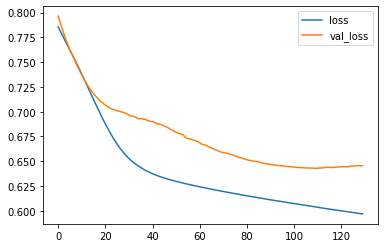

In [33]:
oPredictiveModel = Long_Short_Term_Memory(
    sSubModelName, 
    dfScaledInputTrain.shape[1], 
    1,
    len(g_aBackwardTimeSteps), 
    1
    )

oPredictiveModel.Train(dfBalancedInputTrain, 
                       dfBalancedOutputTrain,
                       dfScaledInputValidation,
                       dfOutputValidation
                      )

## Test

In [34]:
aPredictionProb, _ = oPredictiveModel.aPredict(dfScaledInputTest)

aPrediction = aPredictionProb.round()

dfPrediction = pd.DataFrame(aPrediction, index = dfInputTest.index)
dfPrediction.columns = aColumns

In [35]:
dfPrediction.value_counts()

(1, 3)
1.0       1240
0.0        452
dtype: int64

In [36]:
print(classification_report(dfOutputTest, dfPrediction))

              precision    recall  f1-score   support

         0.0       0.75      0.42      0.54       821
         1.0       0.61      0.87      0.72       871

    accuracy                           0.65      1692
   macro avg       0.68      0.64      0.63      1692
weighted avg       0.68      0.65      0.63      1692



# DIRECTIONAL MODEL

In [37]:
sModelName = os.path.join(sSymbol , "__directional model__")

In [38]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [39]:
dfInputDirectional = dfInput.copy()
dfOutputDirectional = dfOutput.copy()

In [40]:
dfMaskUpward = dfClose>dfOpen
dfMaskDownward = dfClose<dfOpen 

dfOutputDirectional.loc[(dfMaskInvestable) & (dfMaskDownward)] = 0
dfOutputDirectional.loc[(dfMaskInvestable) & (dfMaskUpward)] = 1

In [41]:
dfOutputDirectional

From,1
To,3
time,
2021-01-05 02:00:00,1
2021-01-05 02:30:00,1
2021-01-05 03:00:00,NaN
2021-01-05 03:30:00,NaN
2021-01-05 04:00:00,NaN
...,...
2021-09-21 21:30:00,1
2021-09-21 22:00:00,0


### Remove Empty Rows

In [42]:
aMissingOutputs = dfOutputDirectional[dfOutputDirectional.isna().any(axis=1)].index
dfInputDirectional.drop(aMissingOutputs, inplace = True)
dfOutputDirectional.drop(aMissingOutputs, inplace = True)

### Split Data

In [43]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputDirectional, 
                                                                                                            dfOutputDirectional)

### Scale Data

In [44]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest)

### Balance Classes

In [45]:
dfOutputTrain.value_counts()

(1, 3)
1.0       1073
0.0       1003
dtype: int64

In [46]:
dfBalancedInputTrain , dfBalancedOutputTrain = dfOversampleImbalancedData(
    dfScaledInputTrain,
    dfOutputTrain)
dfBalancedOutputTrain.columns = aColumns

In [47]:
dfBalancedOutputTrain.value_counts()

(1, 3)
0.0       1073
1.0       1073
dtype: int64

In [48]:
dfOutputValidation.value_counts()

(1, 3)
1.0       371
0.0       321
dtype: int64

In [49]:
dfOutputTest.value_counts()

(1, 3)
1.0       382
0.0       310
dtype: int64

## Train

Epoch 1/10000
34/34 [==============================] - 3s 21ms/step - loss: 0.7844 - val_loss: 0.8100
Epoch 2/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7841 - val_loss: 0.8101
Epoch 3/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7838 - val_loss: 0.8100
Epoch 4/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7835 - val_loss: 0.8098
Epoch 5/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7832 - val_loss: 0.8098
Epoch 6/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7829 - val_loss: 0.8096
Epoch 7/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7826 - val_loss: 0.8096
Epoch 8/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7823 - val_loss: 0.8095
Epoch 9/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7820 - val_loss: 0.8095
Epoch 10/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7817 - val_l

34/34 [==============================] - 0s 10ms/step - loss: 0.7663 - val_loss: 0.8024
Epoch 82/10000
34/34 [==============================] - 0s 9ms/step - loss: 0.7661 - val_loss: 0.8022
Epoch 83/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7659 - val_loss: 0.8022
Epoch 84/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7658 - val_loss: 0.8021
Epoch 85/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7656 - val_loss: 0.8020
Epoch 86/10000
34/34 [==============================] - 0s 9ms/step - loss: 0.7654 - val_loss: 0.8018
Epoch 87/10000
34/34 [==============================] - 0s 10ms/step - loss: 0.7652 - val_loss: 0.8017
Epoch 88/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7650 - val_loss: 0.8017
Epoch 89/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7648 - val_loss: 0.8016
Epoch 90/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7646 - val_loss: 

34/34 [==============================] - 0s 9ms/step - loss: 0.7529 - val_loss: 0.7978
Epoch 161/10000
34/34 [==============================] - 0s 9ms/step - loss: 0.7528 - val_loss: 0.7978
Epoch 162/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7526 - val_loss: 0.7977
Epoch 163/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7525 - val_loss: 0.7977
Epoch 164/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7523 - val_loss: 0.7976
Epoch 165/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7522 - val_loss: 0.7976
Epoch 166/10000
34/34 [==============================] - 0s 7ms/step - loss: 0.7520 - val_loss: 0.7975
Epoch 167/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7519 - val_loss: 0.7974
Epoch 168/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7517 - val_loss: 0.7973
Epoch 169/10000
34/34 [==============================] - 0s 8ms/step - loss: 0.7516 - val

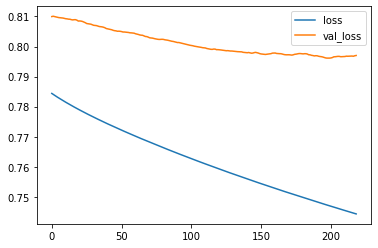

In [50]:
oPredictiveModel = Long_Short_Term_Memory(
    sSubModelName, 
    dfScaledInputTrain.shape[1], 
    1,
    len(g_aBackwardTimeSteps), 
    1
    )

oPredictiveModel.Train(dfBalancedInputTrain, 
                       dfBalancedOutputTrain,
                       dfScaledInputValidation,
                       dfOutputValidation
                      )

## Test

In [51]:
aPredictionProb, _ = oPredictiveModel.aPredict(dfScaledInputTest)

aPrediction = aPredictionProb.round()

dfPrediction = pd.DataFrame(aPrediction, index = dfInputTest.index)
dfPrediction.columns = aColumns

In [52]:
dfPrediction.value_counts()

(1, 3)
0.0       692
dtype: int64

In [53]:
print(classification_report(dfOutputTest, dfPrediction))

              precision    recall  f1-score   support

         0.0       0.45      1.00      0.62       310
         1.0       0.00      0.00      0.00       382

    accuracy                           0.45       692
   macro avg       0.22      0.50      0.31       692
weighted avg       0.20      0.45      0.28       692



C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\yunus\AppData\Local\Continuum\anaconda3\envs\tf-gpu\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  

# UPWARD REGRESSION MODEL

In [54]:
sModelName = os.path.join(sSymbol , "__upward regression model__")

In [55]:
sSubModelName = os.path.join(sModelName , "__"+ str(i) +"  " + str(j) + "__")

## Preprocessing

In [56]:
dfInputUpward = dfInput.copy()
dfOutputUpward = dfOutput.copy()

In [57]:
dfOutputUpward.loc[dfMaskInvestable & dfMaskUpward, i] = dfReturn.loc[dfOutputUpward.index].loc[dfMaskInvestable & dfMaskUpward].values

In [58]:
dfOutputUpward

From,1
To,3
time,
2021-01-05 02:00:00,0.005027
2021-01-05 02:30:00,0.004635
2021-01-05 03:00:00,NaN
2021-01-05 03:30:00,NaN
2021-01-05 04:00:00,NaN
...,...
2021-09-21 21:30:00,0.001237
2021-09-21 22:00:00,NaN


### Remove Empty Rows

In [59]:
aMissingOutputs = dfOutputUpward[dfOutputUpward.isna().any(axis=1)].index
dfInputUpward.drop(aMissingOutputs, inplace = True)
dfOutputUpward.drop(aMissingOutputs, inplace = True)

### Split Data

In [60]:
dfInputTrain, dfInputValidation, dfInputTest, dfOutputTrain, dfOutputValidation, dfOutputTest = dfSplitData(dfInputUpward, 
                                                                                                            dfOutputUpward)

### Scale Data

In [61]:
dfScaledInputTrain, dfScaledInputValidation, dfScaledInputTest = dfScaleData("input", dfInputTrain,dfInputValidation, dfInputTest)

## Train

Epoch 1/10000
18/18 [==============================] - 3s 41ms/step - loss: 0.1270 - val_loss: 0.7213
Epoch 2/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1241 - val_loss: 0.6776
Epoch 3/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1215 - val_loss: 0.6379
Epoch 4/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1190 - val_loss: 0.5968
Epoch 5/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1166 - val_loss: 0.5613
Epoch 6/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1145 - val_loss: 0.5296
Epoch 7/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1125 - val_loss: 0.4992
Epoch 8/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1107 - val_loss: 0.4710
Epoch 9/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1089 - val_loss: 0.4450
Epoch 10/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.1073 - val_l

18/18 [==============================] - 0s 8ms/step - loss: 0.0829 - val_loss: 0.0924
Epoch 82/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0827 - val_loss: 0.0920
Epoch 83/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0826 - val_loss: 0.0917
Epoch 84/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0825 - val_loss: 0.0915
Epoch 85/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0824 - val_loss: 0.0912
Epoch 86/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0823 - val_loss: 0.0909
Epoch 87/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0821 - val_loss: 0.0906
Epoch 88/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0820 - val_loss: 0.0904
Epoch 89/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0819 - val_loss: 0.0902
Epoch 90/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0818 - val_loss: 0.

Epoch 161/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0733 - val_loss: 0.0767
Epoch 162/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0732 - val_loss: 0.0766
Epoch 163/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0731 - val_loss: 0.0764
Epoch 164/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0729 - val_loss: 0.0763
Epoch 165/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0728 - val_loss: 0.0761
Epoch 166/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0727 - val_loss: 0.0759
Epoch 167/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0726 - val_loss: 0.0758
Epoch 168/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0724 - val_loss: 0.0756
Epoch 169/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0723 - val_loss: 0.0755
Epoch 170/10000
18/18 [==============================] - 0s 8ms/step - lo

18/18 [==============================] - 0s 8ms/step - loss: 0.0635 - val_loss: 0.0651
Epoch 241/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0634 - val_loss: 0.0649
Epoch 242/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0632 - val_loss: 0.0648
Epoch 243/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0631 - val_loss: 0.0647
Epoch 244/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0630 - val_loss: 0.0645
Epoch 245/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0629 - val_loss: 0.0644
Epoch 246/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0627 - val_loss: 0.0642
Epoch 247/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0626 - val_loss: 0.0641
Epoch 248/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0625 - val_loss: 0.0639
Epoch 249/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0624 - val

18/18 [==============================] - 0s 9ms/step - loss: 0.0537 - val_loss: 0.0546
Epoch 320/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0536 - val_loss: 0.0545
Epoch 321/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.0535 - val_loss: 0.0543
Epoch 322/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0534 - val_loss: 0.0542
Epoch 323/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0533 - val_loss: 0.0541
Epoch 324/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0531 - val_loss: 0.0540
Epoch 325/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0530 - val_loss: 0.0538
Epoch 326/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0529 - val_loss: 0.0537
Epoch 327/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0528 - val_loss: 0.0536
Epoch 328/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0527 - val

18/18 [==============================] - 0s 11ms/step - loss: 0.0446 - val_loss: 0.0451
Epoch 399/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0445 - val_loss: 0.0450
Epoch 400/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0444 - val_loss: 0.0449
Epoch 401/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0443 - val_loss: 0.0448
Epoch 402/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0442 - val_loss: 0.0446
Epoch 403/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0441 - val_loss: 0.0445
Epoch 404/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0440 - val_loss: 0.0444
Epoch 405/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0439 - val_loss: 0.0443
Epoch 406/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0438 - val_loss: 0.0442
Epoch 407/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0436 - 

18/18 [==============================] - 0s 8ms/step - loss: 0.0364 - val_loss: 0.0367
Epoch 478/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0363 - val_loss: 0.0366
Epoch 479/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0362 - val_loss: 0.0365
Epoch 480/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0361 - val_loss: 0.0364
Epoch 481/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0360 - val_loss: 0.0363
Epoch 482/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0360 - val_loss: 0.0362
Epoch 483/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0359 - val_loss: 0.0361
Epoch 484/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0358 - val_loss: 0.0360
Epoch 485/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0357 - val_loss: 0.0359
Epoch 486/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0356 - val

18/18 [==============================] - 0s 8ms/step - loss: 0.0293 - val_loss: 0.0294
Epoch 557/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0292 - val_loss: 0.0293
Epoch 558/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0291 - val_loss: 0.0292
Epoch 559/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0290 - val_loss: 0.0292
Epoch 560/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0289 - val_loss: 0.0291
Epoch 561/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0288 - val_loss: 0.0290
Epoch 562/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0288 - val_loss: 0.0289
Epoch 563/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0287 - val_loss: 0.0288
Epoch 564/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.0286 - val_loss: 0.0287
Epoch 565/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0285 - val

18/18 [==============================] - 0s 8ms/step - loss: 0.0231 - val_loss: 0.0232
Epoch 636/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0230 - val_loss: 0.0231
Epoch 637/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0230 - val_loss: 0.0230
Epoch 638/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0229 - val_loss: 0.0230
Epoch 639/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0228 - val_loss: 0.0229
Epoch 640/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0228 - val_loss: 0.0228
Epoch 641/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0227 - val_loss: 0.0228
Epoch 642/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0226 - val_loss: 0.0227
Epoch 643/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0225 - val_loss: 0.0226
Epoch 644/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.0225 - val

18/18 [==============================] - 0s 8ms/step - loss: 0.0179 - val_loss: 0.0180
Epoch 715/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0179 - val_loss: 0.0179
Epoch 716/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0178 - val_loss: 0.0178
Epoch 717/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0177 - val_loss: 0.0178
Epoch 718/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0177 - val_loss: 0.0177
Epoch 719/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0176 - val_loss: 0.0177
Epoch 720/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0176 - val_loss: 0.0176
Epoch 721/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0175 - val_loss: 0.0175
Epoch 722/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0174 - val_loss: 0.0175
Epoch 723/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0174 - val

18/18 [==============================] - 0s 8ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 794/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0136
Epoch 795/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 796/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0134 - val_loss: 0.0135
Epoch 797/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0134 - val_loss: 0.0134
Epoch 798/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0133 - val_loss: 0.0134
Epoch 799/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0133 - val_loss: 0.0133
Epoch 800/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0132 - val_loss: 0.0133
Epoch 801/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 802/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0131 - val

18/18 [==============================] - 0s 8ms/step - loss: 0.0101 - val_loss: 0.0101
Epoch 873/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 874/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.0100 - val_loss: 0.0100
Epoch 875/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 876/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 877/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0099 - val_loss: 0.0099
Epoch 878/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 879/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.0098 - val_loss: 0.0098
Epoch 880/10000
18/18 [==============================] - 0s 7ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 881/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0097 - val

18/18 [==============================] - 0s 8ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 952/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 953/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0072 - val_loss: 0.0071
Epoch 954/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 955/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 956/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 957/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 958/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 959/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 960/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0069 - va

18/18 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 1031/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0050
Epoch 1032/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0050 - val_loss: 0.0049
Epoch 1033/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 1034/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 1035/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 1036/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0049 - val_loss: 0.0049
Epoch 1037/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 1038/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0048 - val_loss: 0.0048
Epoch 1039/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0

Epoch 1109/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 1110/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 1111/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 1112/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 1113/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0033 - val_loss: 0.0032
Epoch 1114/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 1115/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 1116/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 1117/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0032 - val_loss: 0.0032
Epoch 1118/10000
18/18 [==============================] - 0s 9ms

18/18 [==============================] - 0s 9ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1188/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1189/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1190/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1191/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0021
Epoch 1192/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0021 - val_loss: 0.0020
Epoch 1193/10000
18/18 [==============================] - 0s 10ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1194/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1195/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0020 - val_loss: 0.0020
Epoch 1196/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.

Epoch 1266/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 1267/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1268/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 1269/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1270/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1271/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1272/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1273/10000
18/18 [==============================] - 0s 9ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1274/10000
18/18 [==============================] - 0s 8ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 1275/10000
18/18 [==============================] - 0s 9ms

18/18 [==============================] - 0s 8ms/step - loss: 7.2960e-04 - val_loss: 7.1701e-04
Epoch 1342/10000
18/18 [==============================] - 0s 8ms/step - loss: 7.2389e-04 - val_loss: 7.1126e-04
Epoch 1343/10000
18/18 [==============================] - 0s 8ms/step - loss: 7.1825e-04 - val_loss: 7.0560e-04
Epoch 1344/10000
18/18 [==============================] - 0s 8ms/step - loss: 7.1264e-04 - val_loss: 7.0009e-04
Epoch 1345/10000
18/18 [==============================] - 0s 8ms/step - loss: 7.0706e-04 - val_loss: 6.9443e-04
Epoch 1346/10000
18/18 [==============================] - 0s 8ms/step - loss: 7.0155e-04 - val_loss: 6.8905e-04
Epoch 1347/10000
18/18 [==============================] - 0s 8ms/step - loss: 6.9603e-04 - val_loss: 6.8360e-04
Epoch 1348/10000
18/18 [==============================] - 0s 8ms/step - loss: 6.9056e-04 - val_loss: 6.7804e-04
Epoch 1349/10000
18/18 [==============================] - 0s 8ms/step - loss: 6.8513e-04 - val_loss: 6.7266e-04
Epoch 135

18/18 [==============================] - 0s 8ms/step - loss: 3.9998e-04 - val_loss: 3.8832e-04
Epoch 1415/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.9650e-04 - val_loss: 3.8500e-04
Epoch 1416/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.9310e-04 - val_loss: 3.8148e-04
Epoch 1417/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.8968e-04 - val_loss: 3.7808e-04
Epoch 1418/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.8630e-04 - val_loss: 3.7472e-04
Epoch 1419/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.8298e-04 - val_loss: 3.7149e-04
Epoch 1420/10000
18/18 [==============================] - 0s 7ms/step - loss: 3.7966e-04 - val_loss: 3.6802e-04
Epoch 1421/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.7635e-04 - val_loss: 3.6476e-04
Epoch 1422/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.7309e-04 - val_loss: 3.6176e-04
Epoch 142

18/18 [==============================] - 0s 8ms/step - loss: 2.0815e-04 - val_loss: 1.9703e-04
Epoch 1488/10000
18/18 [==============================] - 0s 8ms/step - loss: 2.0625e-04 - val_loss: 1.9515e-04
Epoch 1489/10000
18/18 [==============================] - 0s 8ms/step - loss: 2.0435e-04 - val_loss: 1.9369e-04
Epoch 1490/10000
18/18 [==============================] - 0s 8ms/step - loss: 2.0267e-04 - val_loss: 1.9143e-04
Epoch 1491/10000
18/18 [==============================] - 0s 8ms/step - loss: 2.0062e-04 - val_loss: 1.8960e-04
Epoch 1492/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.9879e-04 - val_loss: 1.8776e-04
Epoch 1493/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.9697e-04 - val_loss: 1.8595e-04
Epoch 1494/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.9517e-04 - val_loss: 1.8419e-04
Epoch 1495/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.9339e-04 - val_loss: 1.8243e-04
Epoch 149

18/18 [==============================] - 0s 8ms/step - loss: 1.0676e-04 - val_loss: 9.6068e-05
Epoch 1561/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.0581e-04 - val_loss: 9.5114e-05
Epoch 1562/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.0489e-04 - val_loss: 9.4189e-05
Epoch 1563/10000
18/18 [==============================] - 0s 9ms/step - loss: 1.0395e-04 - val_loss: 9.3278e-05
Epoch 1564/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.0304e-04 - val_loss: 9.2357e-05
Epoch 1565/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.0214e-04 - val_loss: 9.1433e-05
Epoch 1566/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.0121e-04 - val_loss: 9.0539e-05
Epoch 1567/10000
18/18 [==============================] - 0s 8ms/step - loss: 1.0033e-04 - val_loss: 8.9640e-05
Epoch 1568/10000
18/18 [==============================] - 0s 8ms/step - loss: 9.9458e-05 - val_loss: 8.8759e-05
Epoch 156

18/18 [==============================] - 0s 10ms/step - loss: 5.8955e-05 - val_loss: 4.8424e-05
Epoch 1634/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.8589e-05 - val_loss: 4.7977e-05
Epoch 1635/10000
18/18 [==============================] - 0s 10ms/step - loss: 5.8092e-05 - val_loss: 4.7586e-05
Epoch 1636/10000
18/18 [==============================] - 0s 13ms/step - loss: 5.7703e-05 - val_loss: 4.7157e-05
Epoch 1637/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.7305e-05 - val_loss: 4.6782e-05
Epoch 1638/10000
18/18 [==============================] - 0s 21ms/step - loss: 5.6913e-05 - val_loss: 4.6370e-05
Epoch 1639/10000
18/18 [==============================] - 0s 10ms/step - loss: 5.6500e-05 - val_loss: 4.5987e-05
Epoch 1640/10000
18/18 [==============================] - 0s 10ms/step - loss: 5.6125e-05 - val_loss: 4.5606e-05
Epoch 1641/10000
18/18 [==============================] - 0s 11ms/step - loss: 5.5777e-05 - val_loss: 4.5239e-05


Epoch 1706/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.9686e-05 - val_loss: 2.9320e-05
Epoch 1707/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.9574e-05 - val_loss: 2.9079e-05
Epoch 1708/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.9399e-05 - val_loss: 2.8960e-05
Epoch 1709/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.9260e-05 - val_loss: 2.8812e-05
Epoch 1710/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.9150e-05 - val_loss: 2.8661e-05
Epoch 1711/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.8984e-05 - val_loss: 2.8555e-05
Epoch 1712/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.8822e-05 - val_loss: 2.8383e-05
Epoch 1713/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.8748e-05 - val_loss: 2.8254e-05
Epoch 1714/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.8582e-05 - val_loss: 2.8

18/18 [==============================] - 0s 8ms/step - loss: 3.3725e-05 - val_loss: 2.3313e-05
Epoch 1780/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.3724e-05 - val_loss: 2.3322e-05
Epoch 1781/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.3653e-05 - val_loss: 2.3240e-05
Epoch 1782/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.3642e-05 - val_loss: 2.3284e-05
Epoch 1783/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.3628e-05 - val_loss: 2.3387e-05
Epoch 1784/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.3607e-05 - val_loss: 2.3291e-05
Epoch 1785/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.3562e-05 - val_loss: 2.3206e-05
Epoch 1786/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.3510e-05 - val_loss: 2.3087e-05
Epoch 1787/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.3485e-05 - val_loss: 2.3066e-05
Epoch 178

18/18 [==============================] - 0s 8ms/step - loss: 3.2488e-05 - val_loss: 2.2085e-05
Epoch 1853/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2478e-05 - val_loss: 2.2053e-05
Epoch 1854/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2493e-05 - val_loss: 2.2091e-05
Epoch 1855/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2487e-05 - val_loss: 2.2293e-05
Epoch 1856/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2505e-05 - val_loss: 2.2062e-05
Epoch 1857/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2438e-05 - val_loss: 2.2037e-05
Epoch 1858/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2456e-05 - val_loss: 2.2043e-05
Epoch 1859/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2485e-05 - val_loss: 2.2030e-05
Epoch 1860/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2458e-05 - val_loss: 2.2038e-05
Epoch 186

18/18 [==============================] - 0s 8ms/step - loss: 3.2303e-05 - val_loss: 2.1912e-05
Epoch 1926/10000
18/18 [==============================] - 0s 9ms/step - loss: 3.2310e-05 - val_loss: 2.1900e-05
Epoch 1927/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2344e-05 - val_loss: 2.1896e-05
Epoch 1928/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2351e-05 - val_loss: 2.1895e-05
Epoch 1929/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2324e-05 - val_loss: 2.1997e-05
Epoch 1930/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2333e-05 - val_loss: 2.1909e-05
Epoch 1931/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2309e-05 - val_loss: 2.1935e-05
Epoch 1932/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2324e-05 - val_loss: 2.1961e-05
Epoch 1933/10000
18/18 [==============================] - 0s 8ms/step - loss: 3.2308e-05 - val_loss: 2.1893e-05
Epoch 193

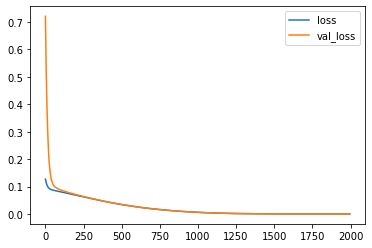

In [67]:
oPredictiveModel = Long_Short_Term_Memory(
    sSubModelName, 
    dfScaledInputTrain.shape[1], 
    1,
    len(g_aBackwardTimeSteps), 
    1,
    False
    )

oPredictiveModel.Train(dfScaledInputTrain, 
                       dfOutputTrain,
                       dfScaledInputValidation,
                       dfOutputValidation
                      )

## Test

In [70]:
aPrediction = oPredictiveModel.aPredict(dfScaledInputTest)
dfPrediction = pd.DataFrame(aPrediction, index = dfScaledInputTest.index)
dfPrediction.columns = aColumns

In [71]:
error = dfOutputTest - dfPrediction

aMetrics = [
        ('mean absolute error', mean_absolute_error(dfOutputTest, dfPrediction)),
        ('median absolute error', median_absolute_error(dfOutputTest, dfPrediction)),
        ('mean squared error', mean_squared_error(dfOutputTest, dfPrediction)),
        ('max error', max_error(dfOutputTest, dfPrediction)),
        ('r2 score', r2_score(dfOutputTest, dfPrediction)),
        ('explained variance score', explained_variance_score(dfOutputTest, dfPrediction))
    ]

print('Metrics for regression:')
for metric_name, metric_value in aMetrics:
    print(f'{metric_name:>25s}: {metric_value: >20.3f}')

Metrics for regression:
      mean absolute error:                0.005
    median absolute error:                0.004
       mean squared error:                0.000
                max error:                0.052
                 r2 score:               -0.000
 explained variance score:                0.000


# DOWNWARD REGRESSION MODEL